In [339]:
#import packages
import pandas as pd
import numpy as np
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import codecs
import string
import os
import re
import seaborn as sns
import keras

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.metrics import precision_recall_fscore_support

from keras.preprocessing import sequence
from keras import Sequential
from keras.optimizers import Adam

from keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Activation, Bidirectional, RepeatVector, Input

In [340]:
#load data
df = pd.read_csv('cleaned_text.csv')

In [341]:
df.head()

,Target,Text
0,Rejected,more than 10600 megawatts of solar power were ...
1,Rejected,smi reports 6 key reasons to attend this years...
2,Completed,dive insight utilities are beginning to see th...
3,Completed,united renewable energy and constellation an e...
4,Completed,march 30 renewables now juwi hellas a unit of ...


In [342]:
df['Length'] = df['Text'].apply(len)
df.sort_values(by='Length', ascending=False).head(10)

,Target,Text,Length
2272,Rejected,correspondence to professor quancheng kan depa...,34541
798,Completed,boralex announces agreement to acquire invener...,28549
2022,Rejected,equity research weekly report july 20 2018 the...,16606
1313,Rejected,the university of michigan partnered with dte ...,15618
1316,Rejected,html xmlnsvurnschemasmicrosoftcomvml xmlnsourn...,14353
2131,Rejected,htmlh3redt energy plc red redt sign deal for 7...,13898
1056,Rejected,abstracttop tier growth execution and now topt...,13648
2601,Rejected,far off the beaten track life in the remote va...,13643
477,Completed,delhiheadquartered renewable energy firm hero ...,13471
2144,Completed,by ben potter july 25 financial review the nat...,13126


In [343]:
# what are our shortest sentences?
df.sort_values(by='Length').head(5)

,Target,Text,Length
951,Rejected,0 jun282018 1620 gmt,20
1214,Rejected,copyright 2018 rbc0 aug082018 1135 gmt,38
1155,Rejected,copyright 2018 rbc0 aug022018 1204 gmt,38
1518,Rejected,provider id 002126030 aug022018 1120 gmt,40
136,Rejected,copyright 2018 bmo capital markets0 aug022018 ...,54


## Data Preprocessing

- check classes are balanced

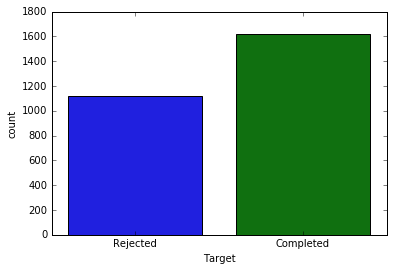

In [344]:
#plot the distribution of the training data
sns.countplot(df['Target'])

The imbalance of classes is effecting how our model trains on the training data, and thus its performance. There are various means to balance classes for classification problems. One of those means is to downsample the majority class, ie, when creating training data for the model, feed it some subset of all the observations in the majority class. The problem with this method is that you tend to throw away valuable data.

A nice alternative is upsampling the minority class, ie, repeating some observations from that class to simulate a greater dataset. The problem with this method is that the model tends to overfit to the training data as it is fed duplicate observations during training.

In [345]:
from sklearn.utils.multiclass import type_of_target
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X = df['Text']
X=X.reshape(-1,1)
y = df['Target']
type_of_target(y)
X_resampled, y_resampled = rus.fit_resample(X, y)

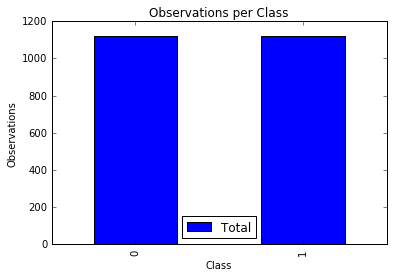

In [346]:
df2 = pd.DataFrame([], columns=['Class','Total'])
df2['Class'] = ["Rejected","Completed"]
df2['Total'] = [pd.value_counts(y_resampled)[0],pd.value_counts(y_resampled)[1]]
df2.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Observations')
plt.title('Observations per Class') #We therefore have imnbalanced classes, but we will continue regarless
plt.show()

In [347]:
#Creating pandas dataframe from numpy array
dataset = pd.DataFrame({'Text':X_resampled[:,0],'Target':y_resampled[:,]})

In [348]:
#split up the training and test data
x_train, x_test, y_train, y_test = train_test_split(dataset['Text'],
                                     dataset['Target'],
                                     test_size=0.20,
                                     random_state=80)

## Tokenize the text
At this stage, the data is still in text format. The next step is to 'numericalize' the data.This process is known as tokenizing, which simply means to create a set of unique IDs to represent all of the words in the corpus.

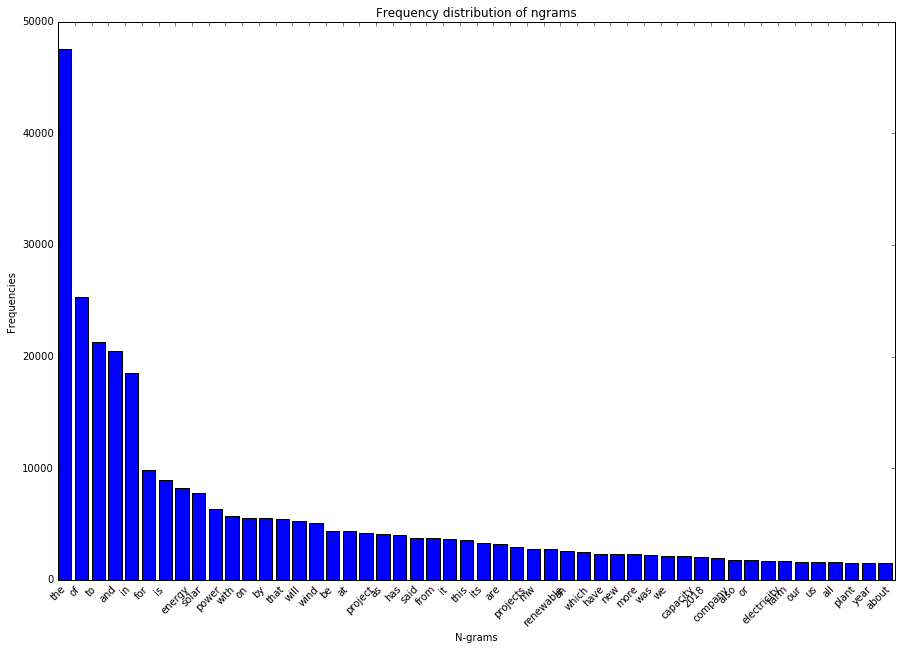

In [349]:
kwargs = {
    'ngram_range' : (1, 1),
    'dtype' : 'int32',
    'strip_accents' : 'unicode',
    'decode_error' : 'replace',
    'analyzer' : 'word'
}

vectorizer = CountVectorizer(**kwargs)
vect_texts = vectorizer.fit_transform(list(dataset['Text']))
all_ngrams = vectorizer.get_feature_names()
num_ngrams = min(50, len(all_ngrams))
all_counts = vect_texts.sum(axis=0).tolist()[0]

all_ngrams, all_counts = zip(*[(n, c) for c, n in sorted(zip(all_counts, all_ngrams), reverse=True)])
ngrams = all_ngrams[:num_ngrams]
counts = all_counts[:num_ngrams]

idx = np.arange(num_ngrams)

plt.figure(figsize=(15, 10))
plt.bar(idx, counts, width=0.8)
plt.xlabel('N-grams')
plt.ylabel('Frequencies')
plt.title('Frequency distribution of ngrams')
plt.xticks(idx, ngrams, rotation=45)
plt.show()

## Prepare the data

- TFIDF matrix

In [350]:
# load whole corpus of words
all_text = dataset['Text'].values
#Total number of words 
sum(counts)

max_words = len(max(dataset['Text'], key=len))

In [383]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

NGRAM_RANGE = (1, 2)
TOP_K = 1000

def ngram_vectorize(train_texts, train_labels, val_texts):
    
    # Learn Vocab from train texts and vectorize train and val sets
    tfidf_vectorizer = TfidfVectorizer(ngram_range=NGRAM_RANGE
                                       ,analyzer = 'word'
                                       ,stop_words = None
                                       ,strip_accents = "ascii"
                                       ,min_df = 2)
    
    x_train = tfidf_vectorizer.fit_transform(train_texts)
    x_val = tfidf_vectorizer.transform(val_texts)
    
    # Select best k features, with feature importance measured by f_classif
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    return x_train, x_val

In [384]:
X_train, X_test = ngram_vectorize(x_train,y_train,x_test)

In [385]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
Y_train = encoder.fit_transform(y_train)
Y_test = encoder.fit_transform(y_test)
print(transfomed_label)

[[0]
 [0]
 [1]
 ...
 [0]
 [1]
 [1]]


## Run Neural Network

In [386]:
model=Sequential()
model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 512)               512512    
_________________________________________________________________
dropout_69 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_82 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_70 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_83 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_71 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_84 (Dense)             (None, 128)               16512     
__________

In [387]:
batch_size = 130
num_epochs = 10

model.compile(loss='binary_crossentropy', 
              #optimizer= Adam(lr=1e-03), 
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, validation_split=0.3)
history = history.history
val_acc = history['val_acc'][-1]
val_loss = history['val_loss'][-1]
print ('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=val_acc, loss=val_loss))

Train on 1256 samples, validate on 539 samples
Epoch 1/10
1256/1256 [==============================] - 2s 1ms/step - loss: 0.6921 - acc: 0.5271 - val_loss: 0.6852 - val_acc: 0.5733
Epoch 2/10
1256/1256 [==============================] - 0s 226us/step - loss: 0.6597 - acc: 0.6401 - val_loss: 0.5981 - val_acc: 0.7236
Epoch 3/10
1256/1256 [==============================] - 0s 226us/step - loss: 0.5224 - acc: 0.8049 - val_loss: 0.3995 - val_acc: 0.8664
Epoch 4/10
1256/1256 [==============================] - 0s 158us/step - loss: 0.3735 - acc: 0.8599 - val_loss: 0.4354 - val_acc: 0.8571
Epoch 5/10
1256/1256 [==============================] - 0s 166us/step - loss: 0.3216 - acc: 0.9029 - val_loss: 0.3382 - val_acc: 0.8646
Epoch 6/10
1256/1256 [==============================] - 0s 163us/step - loss: 0.2508 - acc: 0.9252 - val_loss: 0.3626 - val_acc: 0.8683
Epoch 7/10
1256/1256 [==============================] - 0s 160us/step - loss: 0.2058 - acc: 0.9419 - val_loss: 0.3728 - val_acc: 0.8683
Epo

In [388]:
final_loss, final_acc = model.evaluate(X_train,Y_train, verbose=0)
print("Train loss: {0:.2f}, Train accuracy: {1:.2f}%".format(final_loss, final_acc*100))

Train loss: 0.20, Train accuracy: 94.93%


In [389]:
final_loss, final_acc = model.evaluate(X_test,Y_test,verbose=0)
print("Test loss: {0:.2f}, Test accuracy: {1:.2f}%".format(final_loss, final_acc*100))

Test loss: 0.73, Test accuracy: 83.07%


In [390]:
from sklearn.metrics import confusion_matrix
predictions = model.predict_classes(X_test)

#fetch predictions
preds=predictions.tolist()
y_lbls=Y_test.tolist()

cm_1 = confusion_matrix(y_lbls, preds,labels)
print(pd.DataFrame(cm_1))

     0    1
0  182   50
1   26  191


### Add Threshold

In [401]:
def performance(X_test,Y_test,threshold):
    predictions = model.predict_proba(X_test)
    preds=[1 if i>=threshold else 0 for i in predictions]
    y_lbls = Y_test.tolist()
    cm_1 = confusion_matrix(y_lbls, preds)
    acc = (np.diagonal(cm_1)[1] + np.diagonal(cm_1)[0])/(sum(cm_1)[1]+sum(cm_1)[0])*100
    
    prec1,prec2=precision_recall_fscore_support(y_pred=preds,y_true=y_lbls)[0]
    recall1, recall2= precision_recall_fscore_support(y_pred=preds,y_true=y_lbls)[1]

    
    print("Threshold = {:.2f} \nOver Accuracy: {:.2f}% \nPrecision: [{:.2f},{:.2f}] \nRecall: [{:.2f},{:.2f}] \n\nConfusion Matrix:\n{:}".format(threshold,acc, prec1,prec2,recall1,recall2,pd.DataFrame(cm_1)))

### Training Accuracy

In [402]:
performance(X_train,Y_train,1)

Threshold = 1.00 
Over Accuracy: 57.27% 
Precision: [0.54,1.00] 
Recall: [1.00,0.14] 

Confusion Matrix:
     0    1
0  905    0
1  767  123


### Test Accuracy

In [403]:
performance(X_test,Y_test,1)

Threshold = 1.00 
Over Accuracy: 55.68% 
Precision: [0.52,0.97] 
Recall: [1.00,0.15] 

Confusion Matrix:
     0   1
0  216   1
1  198  34


Above can be seen as the base case - we are able to remove close to $48$% of the work items with 100% precision